In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pymongo import MongoClient
import streamlit as st

Read Data


In [2]:
data = pd.read_csv("indeed_jobs.csv")
df = pd.DataFrame(data)


Data Cleaning

In [3]:

df.drop_duplicates(inplace=True)
df.dropna(subset=['Job Title'], inplace=True)

df['Job Title'] = df['Job Title'].str.lower().str.strip()
df['Location'] = df['Location'].str.strip()

df = df[~df['Pay'].str.contains('hour', case=False, na=False)]
df['Cleaned_Pay'] = df['Pay'].str.replace('[\$,]', '', regex=True)

df['Min_Pay'] = df['Cleaned_Pay'].str.extract(r'(\d+)', expand=False).astype(float)
df['Max_Pay'] = df['Cleaned_Pay'].str.extract(r'(\d+)\s*-\s*(\d+)', expand=True)[1].astype(float)
df['Max_Pay'].fillna(df['Min_Pay'], inplace=True)

df.drop(columns=['Cleaned_Pay'], inplace=True)
df.drop(columns=['Pay'], inplace=True)

df['Rating'].fillna(df['Rating'].mean(), inplace=True)
df['Rating'] = df['Rating'].round(1)
mode_job = df['Job Type'].mode()[0]

df['Job Type'].fillna(mode_job, inplace=True)
df['Min_Pay'].fillna(df['Min_Pay'].mean(), inplace=True)
df['Max_Pay'].fillna(df['Max_Pay'].mean(), inplace=True)

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
C:\Users\nourp\AppData\Local\Temp\ipykernel_16728\227500434.py:8: SyntaxWarning: invalid escape sequence '\$'
  df['Cleaned_Pay'] = df['Pay'].str.replace('[\$,]', '', regex=True)
C:\Users\nourp\AppData\Local\Temp\ipykernel_16728\227500434.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Max_Pay'].fillna(df['Min_Pay'], inplace=True)
C:\Users\nourp\AppData\Local\Temp\ipykernel_16728\227500434.py:17: FutureWarning: A value 

In [4]:
na_counts = df.isna().sum()
print(na_counts)
print(df.shape)

Job Title    0
Location     0
Company      0
Job Type     0
Rating       0
Min_Pay      0
Max_Pay      0
dtype: int64
(651, 7)


Data analysis


In [5]:
top_job_titles = df['Job Title'].value_counts().head(10)
print(top_job_titles)
df['Average_Pay'] = (df['Min_Pay'] + df['Max_Pay']) / 2
df.drop(columns=['Min_Pay', 'Max_Pay'], inplace=True)
print(df.head())
print(df.shape)
average_salary_per_company = df.groupby('Company')['Average_Pay'].mean().sort_values(ascending=False)
print(average_salary_per_company.head(10))  

Job Title
senior software engineer                62
software engineer                       43
software engineer ii                    19
software developer                      10
senior software development engineer    10
sr. software engineer                    8
software engineer - backend              7
software engineer, backend               7
senior full stack software engineer      6
software engineer iii                    6
Name: count, dtype: int64
                                     Job Title           Location  \
0           senior software engineer, frontend             Remote   
2  software engineer (full stack) - green team  Remote in Newtown   
3                         software engineer ii             Denver   
4         senior full stack software developer             Remote   
5                        software engineer iii             Denver   

                        Company   Job Type  Rating  Average_Pay  
0                        Source  Full-time     3.8   

Visualization


C:\Users\nourp\AppData\Local\Temp\ipykernel_16728\2624261319.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette="coolwarm")
C:\Users\nourp\AppData\Local\Temp\ipykernel_16728\2624261319.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=top_locations.values, y=top_locations.index, palette="viridis")
C:\Users\nourp\AppData\Local\Temp\ipykernel_16728\2624261319.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations_count.values, y=top_locations_count.index, palette="mako")


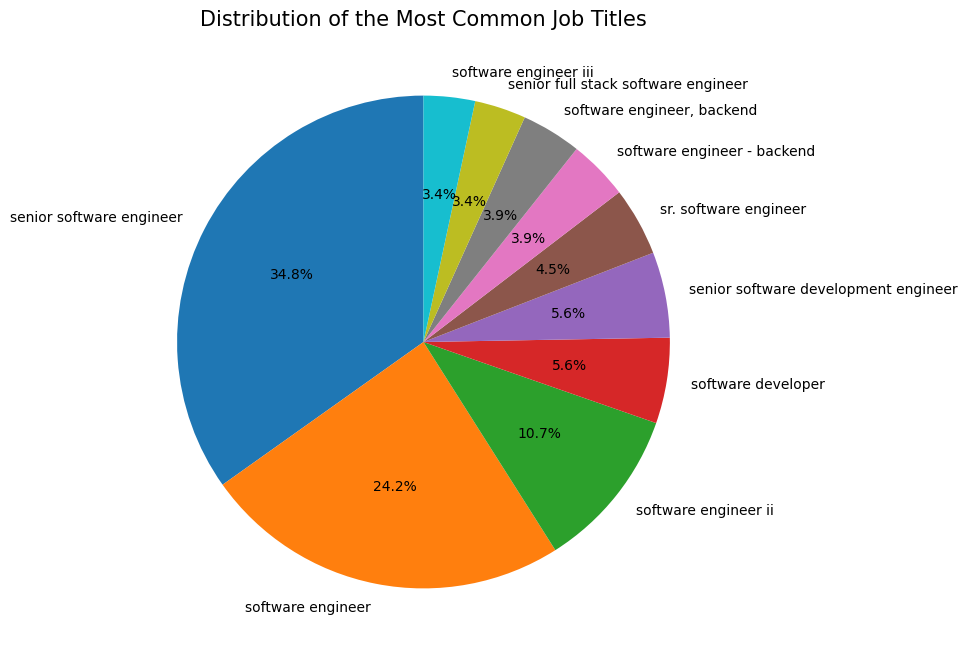

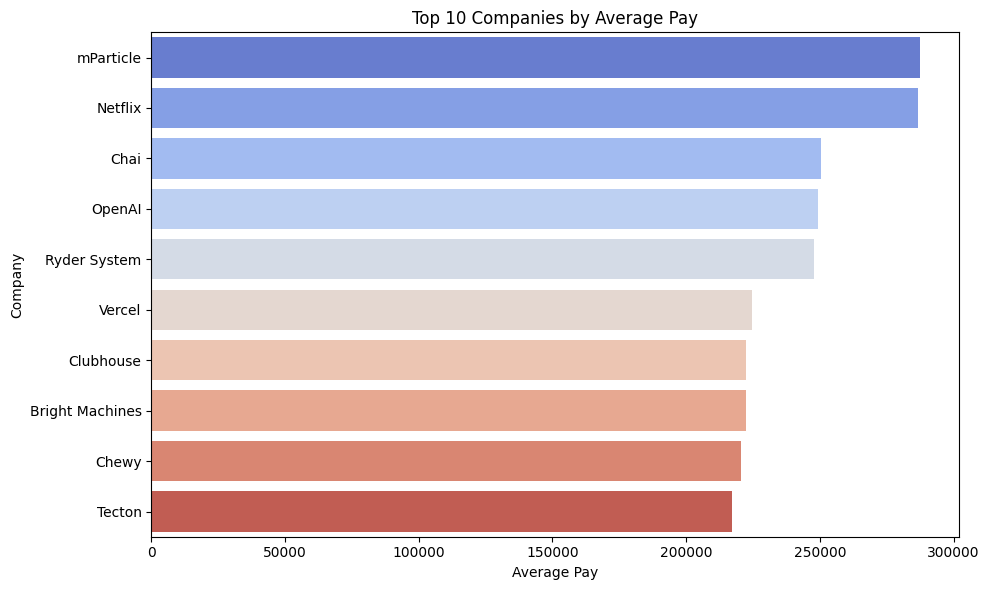

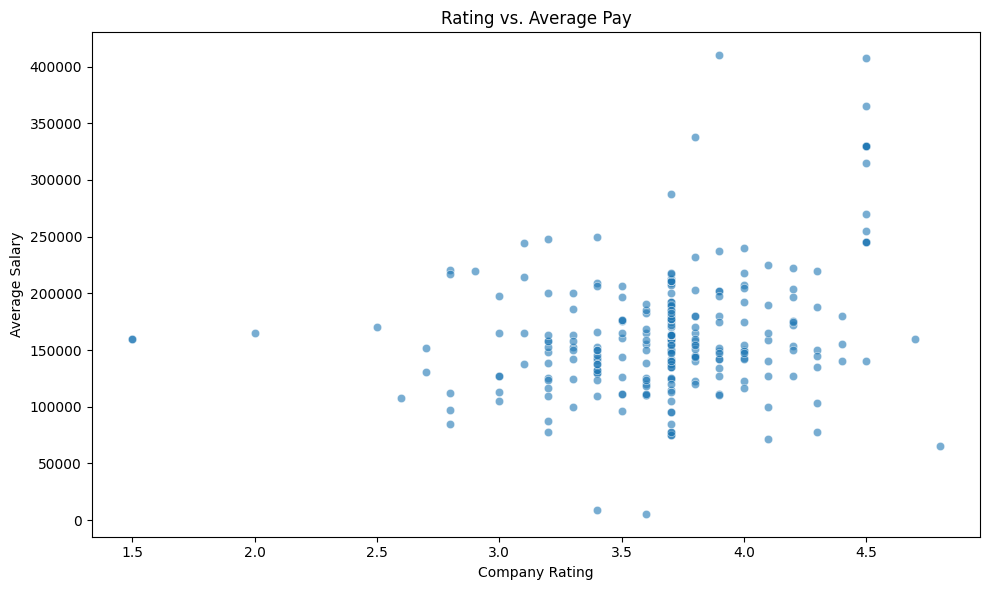

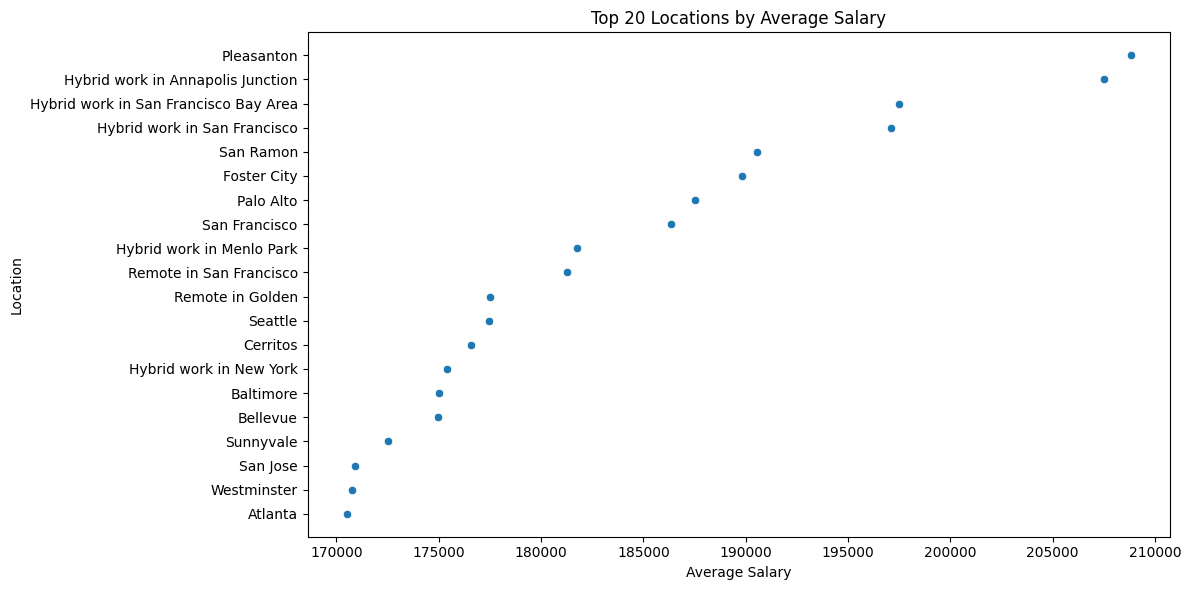

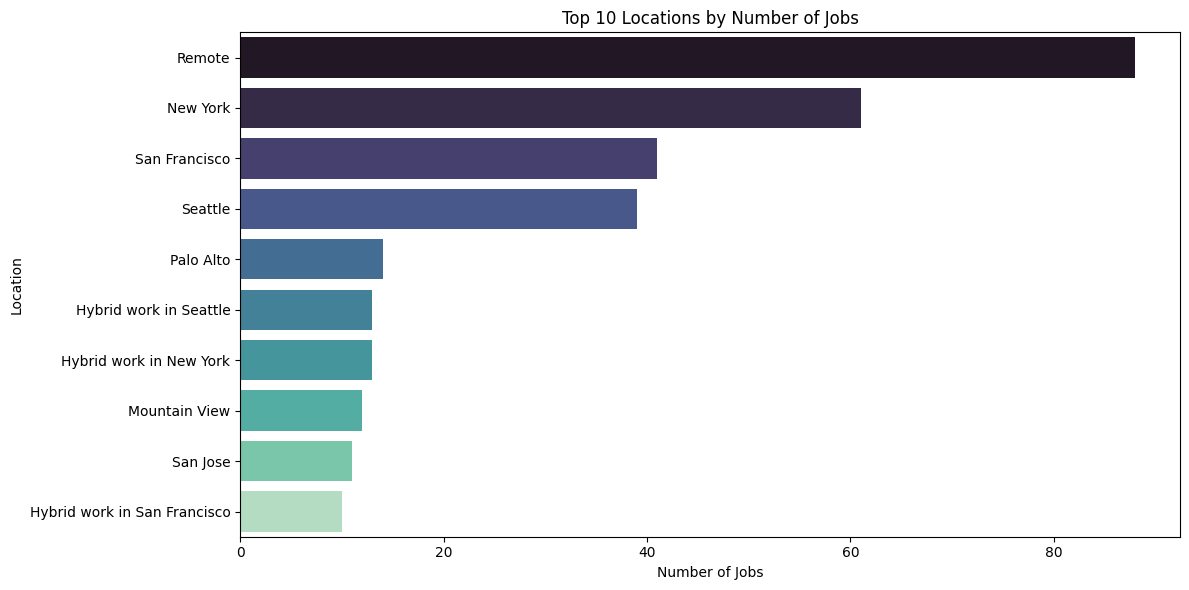

In [6]:
plt.figure(figsize=(10, 8))
plt.pie(
    top_job_titles,
    labels=top_job_titles.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10}
)
plt.title('Distribution of the Most Common Job Titles', fontsize=15)

plt.figure(figsize=(10, 6))
top_companies = average_salary_per_company.head(10)
sns.barplot(x=top_companies.values, y=top_companies.index, palette="coolwarm")
plt.title("Top 10 Companies by Average Pay")
plt.xlabel("Average Pay")
plt.ylabel("Company")
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Average_Pay', data=df, alpha=0.6)
plt.title("Rating vs. Average Pay")
plt.xlabel("Company Rating")
plt.ylabel("Average Salary")
plt.tight_layout()

top_locations = df.groupby('Location')['Average_Pay'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("Top 20 Locations by Average Salary")
plt.xlabel("Average Salary")
plt.ylabel("Location")
plt.tight_layout()

top_locations_count = df['Location'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations_count.values, y=top_locations_count.index, palette="mako")
plt.title("Top 10 Locations by Number of Jobs")
plt.xlabel("Number of Jobs")
plt.tight_layout()

Database (MongoDB)

In [ ]:
# client = MongoClient("mongodb://localhost:27017/")
# print(client.list_database_names())  
# db = client['indeed_jobs_db']
# collection = db['jobs_collection']
# records = df.to_dict(orient='records-+')
# collection.insert_many(records)
# print(" Data successfully saved to MongoDB.")
# for doc in collection.find():
#       print(doc)

Streamlit Dashboard (Bouns)

In [8]:
if __name__ == '__main__':
    st.title("Indeed Jobs Analysis Dashboard")
    # Sidebar
    section = st.sidebar.selectbox(
        "Select Analysis Section",
        ["Top Job Titles", "Top Companies by Pay", "Ratings vs Salary", "Top Locations by Salary", "Top Locations by Job Count"]
    )

    if section == "Top Job Titles":
        st.subheader("Top 10 Job Titles")
        top_jobs = df['Job Title'].value_counts().head(10)
        fig, ax = plt.subplots()
        ax.pie(top_jobs.values, labels=top_jobs.index, autopct='%1.1f%%', startangle=90)
        ax.axis("equal")
        st.pyplot(fig)

    elif section == "Top Companies by Pay":
        st.subheader("Top 10 Companies by Average Pay")
        top_companies = df.groupby('Company')['Average_Pay'].mean().sort_values(ascending=False).head(10)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=top_companies.values, y=top_companies.index, palette="coolwarm", ax=ax)
        ax.set_xlabel("Average Pay")
        st.pyplot(fig)

    elif section == "Ratings vs Salary":
        st.subheader("Company Rating vs. Average Salary")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(data=df, x='Rating', y='Average_Pay', alpha=0.6, ax=ax)
        ax.set_xlabel("Rating")
        ax.set_ylabel("Average Salary")
        st.pyplot(fig)

    elif section == "Top Locations by Salary":
        st.subheader("Top 20 Locations by Average Salary")
        top_locations = df.groupby('Location')['Average_Pay'].mean().sort_values(ascending=False).head(20)
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis", ax=ax)
        ax.set_xlabel("Average Salary")
        st.pyplot(fig)

    elif section == "Top Locations by Job Count":
        st.subheader("Top 10 Locations by Number of Jobs")
        top_location_counts = df['Location'].value_counts().head(10)
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(x=top_location_counts.values, y=top_location_counts.index, palette="mako", ax=ax)
        ax.set_xlabel("Number of Jobs")
        st.pyplot(fig)


2025-05-05 12:57:35.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:57:35.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar